## Import Libraries 

In [1]:
import pandas as pd
import numpy as np
from statistics import mean

from sklearn import tree
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

## Import Data

In [2]:
df = pd.read_csv('Data/ca1-dataset.csv')

## Correlation Heatmap

C:\Users\Cesar\AppData\Local\Temp/ipykernel_10812/2194730385.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),


<AxesSubplot:>

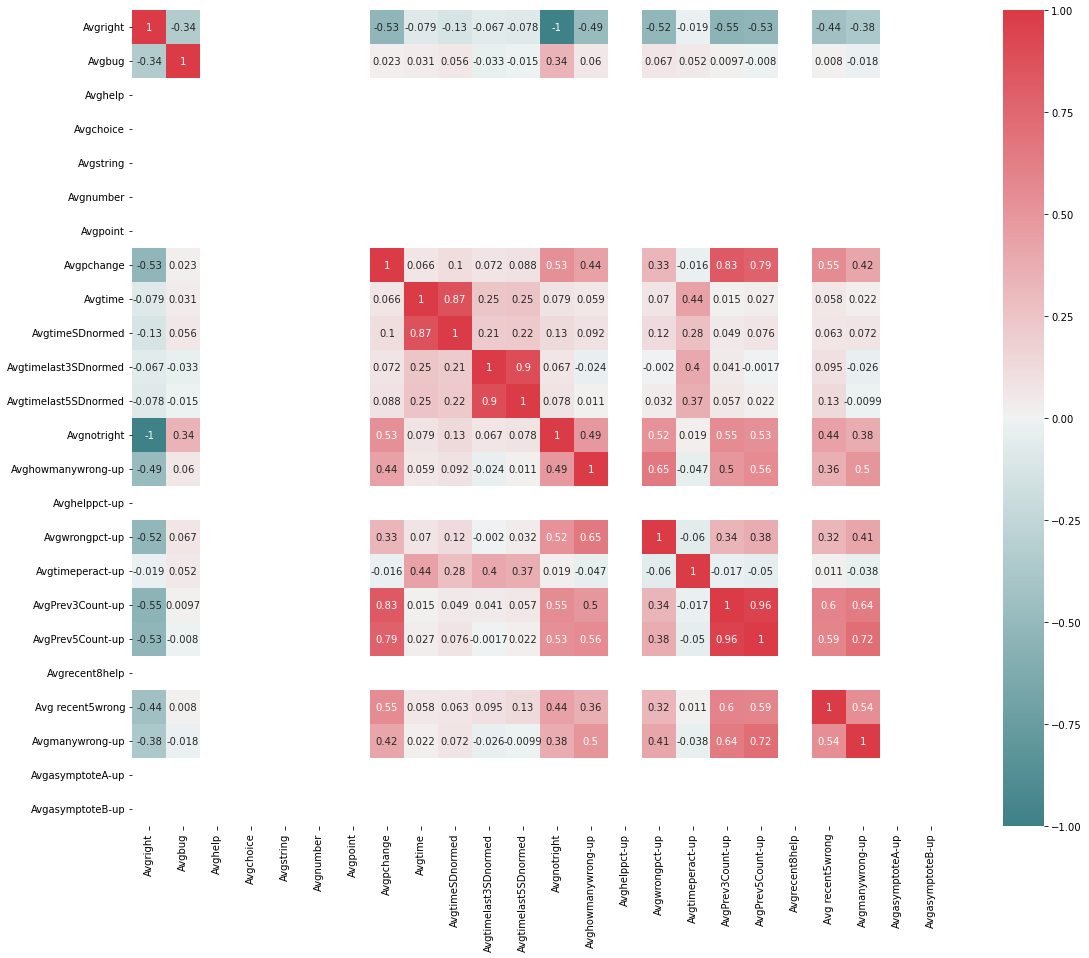

In [3]:
f, ax = plt.subplots(figsize=(20, 15))

corr = df.corr()

sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),
           cmap=sns.diverging_palette(200, 10, as_cmap=True), annot=True,
           square=True, ax=ax)

## Variables

In [4]:
y = df['OffTask']

X = df.drop(columns=['OffTask', 'Unique-id', 'namea', 'Avghelp' ,'Avgchoice','Avgstring', 'Avgpoint',
                     'Avgnumber','Avgrecent8help','Avghelppct-up', 
                     'AvgasymptoteA-up', 'AvgasymptoteB-up', 'AvgPrev5Count-up'], axis=1)

## Model

In [5]:
## Unique ID
group_dict = {}
groups = np.array([])

for index, row in df.iterrows():
    student_id = row['Unique-id']
    if student_id not in group_dict:
        group_dict[student_id] = index
    groups = np.append(groups, group_dict[student_id])


#Create Models

clf_DTC = tree.DecisionTreeClassifier(min_samples_split=10)
clf_GNB = GaussianNB()
clf_XGB = XGBClassifier(learning_rate=0.5, n_estimators=200, random_state=5)
clf_RFC = RandomForestClassifier(random_state=0, criterion='gini')
voting_clf = VotingClassifier(estimators=[('dt' , clf_DTC), ('gnb', clf_GNB), ('xgb',clf_XGB), ('rf',clf_RFC) ], voting='hard')

# Encode Target

label_encoder = LabelEncoder()
y_encoder = label_encoder.fit_transform(y)

kappa_values = list()
ac_values = list()

gkf = GroupKFold(n_splits=10)

for clf in (clf_DTC, clf_GNB, clf_XGB, clf_RFC,voting_clf):
    for train_index, test_index in gkf.split(X, y_encoder, groups=groups):
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y_encoder[train_index]
        y_test = y_encoder[test_index]

        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        kappa = cohen_kappa_score(y_test, predictions)
        ac = accuracy_score(y_test, predictions)
        kappa_values.append(kappa)
        ac_values.append(ac)
        
    mean_kappa = round(mean(kappa_values), 2)
    mean_ac = round(mean(ac_values), 2)
    print("Model Name: ", clf.__class__.__name__, ": Mean kappa: ",mean_kappa, ", Mean Accuaracy Score: ", mean_ac)
    del mean_kappa
    kappa_values.clear()
    ac_values.clear()

Model Name:  DecisionTreeClassifier : Mean kappa:  0.14 , Mean Accuaracy Score:  0.94
Model Name:  GaussianNB : Mean kappa:  0.1 , Mean Accuaracy Score:  0.78
Model Name:  XGBClassifier : Mean kappa:  0.26 , Mean Accuaracy Score:  0.96
Model Name:  RandomForestClassifier : Mean kappa:  0.16 , Mean Accuaracy Score:  0.96
Model Name:  VotingClassifier : Mean kappa:  0.14 , Mean Accuaracy Score:  0.96
